# Big Mart Sales Problem
> The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store. Link to problem [Big Mart Sales](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/)

In [155]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

sns.set()
pd.set_option('display.max_rows', 16)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

In [156]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [157]:
train.shape

(8523, 12)

In [158]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [159]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Some columns have missing values

In [160]:
# some columns have missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [161]:
train.Item_Identifier.unique().shape

(1559,)

# Same items available in different stores at different prices

In [162]:
train[train.Item_Identifier=='FDA15']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
831,FDA15,9.3,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208
2599,FDA15,9.3,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Small,Tier 2,Supermarket Type1,6474.2392
2643,FDA15,9.3,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Medium,Tier 3,Supermarket Type2,5976.2208
4874,FDA15,9.3,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184
5413,FDA15,9.3,Low Fat,0.016009,Dairy,250.6092,OUT013,1987,High,Tier 3,Supermarket Type1,6474.2392
6696,FDA15,NaN,Low Fat,0.015945,Dairy,249.5092,OUT027,1985,Medium,Tier 3,Supermarket Type3,6474.2392
7543,FDA15,9.3,LF,0.016113,Dairy,248.8092,OUT017,2007,NaN,Tier 2,Supermarket Type1,5976.2208


# Combine train and test to compute missing values

In [163]:
# pandas concat rearranges the columns in alphabetical order. Use train.columns to maintain order
combi = pd.concat([train, test], axis='rows', ignore_index=True)[train.columns]

# Fill item weight missing values based on the item identifier

In [164]:
each_item_weight = combi.pivot_table(index=['Item_Identifier'], values=['Item_Weight'], aggfunc=np.nanmean)
for i in each_item_weight.index:
    combi.loc[(combi.Item_Weight.isnull()) & (combi.Item_Identifier==i), 'Item_Weight'] = each_item_weight.Item_Weight[i]

In [165]:
combi.Item_Weight.isnull().sum()

0

# Item_Fat_Content has values which can be combined

In [166]:
combi.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [167]:
combi.Item_Fat_Content = combi.Item_Fat_Content.str.upper()
combi.loc[combi.Item_Fat_Content == 'LF', 'Item_Fat_Content'] = 'LOW FAT'
combi.loc[combi.Item_Fat_Content == 'REG', 'Item_Fat_Content'] = 'REGULAR'

In [168]:
print(combi.Outlet_Identifier.unique())
print(combi.Outlet_Type.unique())

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


# Split the first 2 characters of Item_Identifier as it denotes item classification

In [169]:
# splitting the item identifier e.g. FD, DR
combi['Item_Identifier_Type'] = combi.Item_Identifier.str.slice(0,2)
combi['Item_Identifier_Name'] = combi.Item_Identifier.str.slice(2)

# Outlet_Establishment_Year can be converted to Years of operation by subtracting it form 2013

In [170]:
combi['Years_of_Operation'] = 2013 - combi['Outlet_Establishment_Year']
# drop Outlet_Establishment_Year column
combi = combi[['Item_Identifier', 'Item_Identifier_Type', 'Item_Identifier_Name', 'Item_Weight', 'Item_Fat_Content', 
               'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Years_of_Operation', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales']]

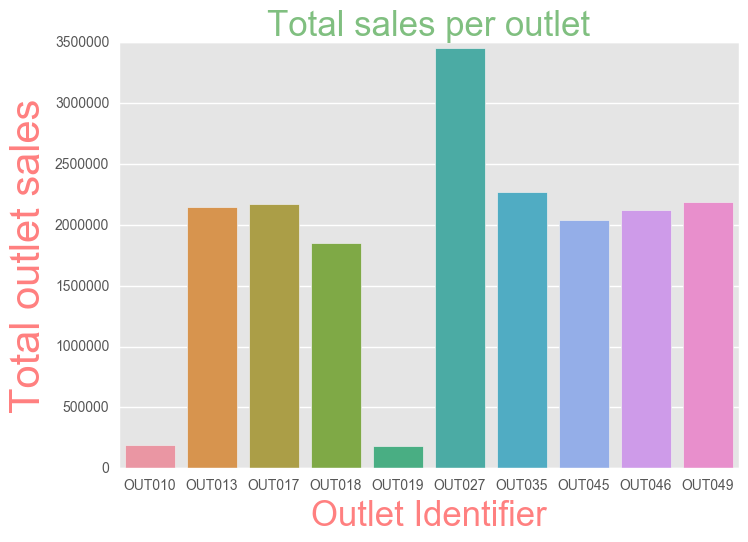

In [171]:
# Total Sales per outlet
total_outlet_sales = combi.groupby('Outlet_Identifier').agg({'Item_Outlet_Sales':np.nansum})
ax = sns.barplot(x=total_outlet_sales.index, y=total_outlet_sales.Item_Outlet_Sales)
ax.set_title('Total sales per outlet', alpha=0.5, color='green', size=25)
ax.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=25)
ax.set_ylabel('Total outlet sales', alpha=0.5, color='red', size=30)

In [172]:
combi.isnull().sum()

Item_Identifier            0
Item_Identifier_Type       0
Item_Identifier_Name       0
Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Identifier          0
Years_of_Operation         0
Outlet_Size             4016
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales       5681
dtype: int64

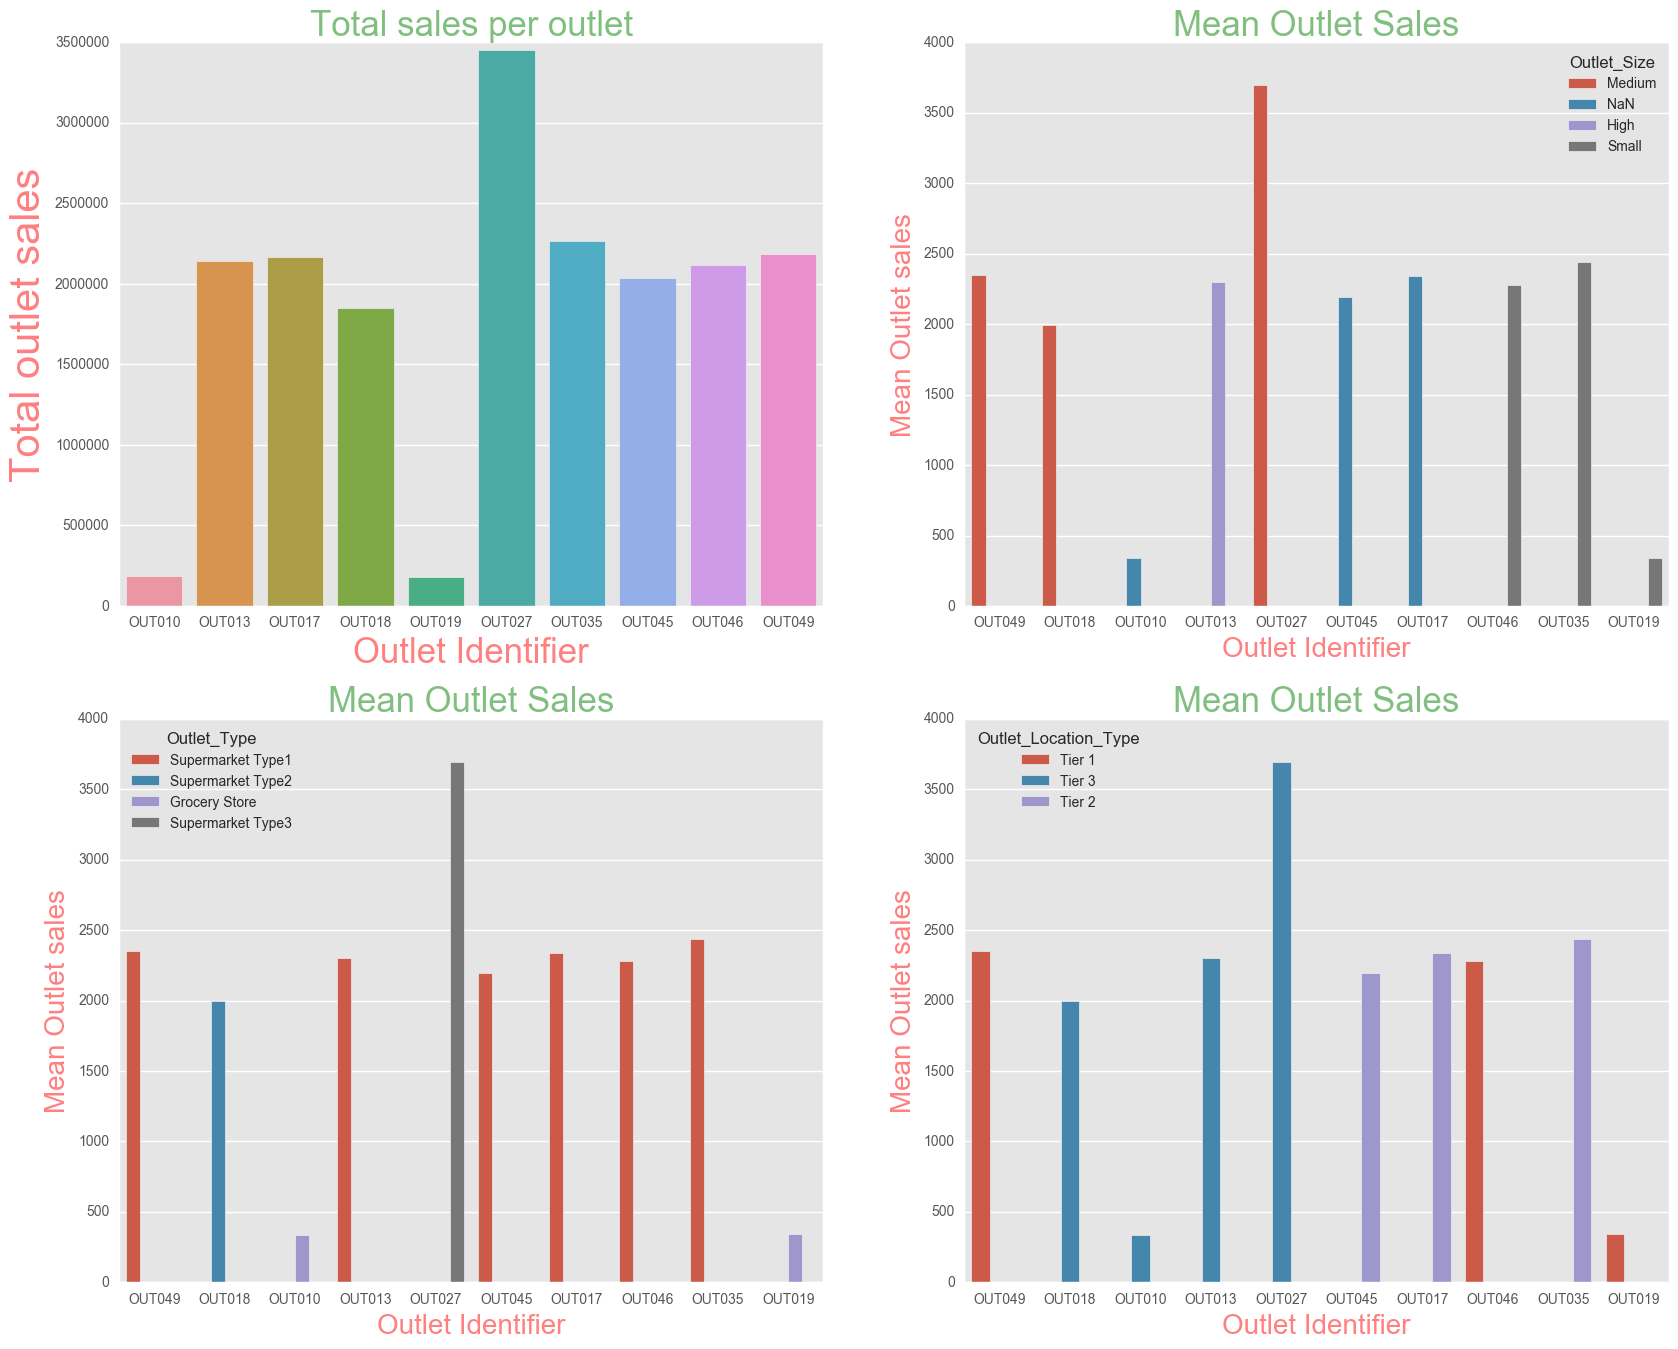

In [173]:
fig, axes = plt.subplots(figsize=(20,16), nrows=2, ncols=2)

ax1 = sns.barplot(x=total_outlet_sales.index, y=total_outlet_sales.Item_Outlet_Sales, ax=axes[0,0])
ax1.set_title('Total sales per outlet', alpha=0.5, color='green', size=25)
ax1.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=25)
ax1.set_ylabel('Total outlet sales', alpha=0.5, color='red', size=30)

ax2 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Size.fillna('NaN'), 
                  ci=None, ax=axes[0,1])
ax2.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax2.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax2.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

ax3 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Type, ci=None, ax=axes[1,0])
ax3.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax3.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax3.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

ax4 = sns.barplot(x=combi.Outlet_Identifier, y=combi.Item_Outlet_Sales, hue=combi.Outlet_Location_Type, ci=None, ax=axes[1,1])
ax4.set_title('Mean Outlet Sales', alpha=0.5, color='green', size=25)
ax4.set_xlabel('Outlet Identifier', alpha=0.5, color='red', size=20)
ax4.set_ylabel('Mean Outlet sales', alpha=0.5, color='red', size=20)

In [174]:
# looking at first 2 plots, we can say that outlet 010 is small
combi.loc[combi.Outlet_Identifier=='OUT010', 'Outlet_Size'] = 'Small'
combi.loc[combi.Outlet_Identifier=='OUT045', 'Outlet_Size'] = 'Medium'
combi.loc[combi.Outlet_Identifier=='OUT017', 'Outlet_Size'] = 'Medium'

In [175]:
# Assuming given products are all the products that a store has. Total visibility of all items in a store should be 100
combi.pivot_table(index=['Outlet_Identifier'], values=['Item_Visibility'], aggfunc=np.sum)

,Item_Visibility
Outlet_Identifier,
OUT010,94.293418
OUT013,93.555174
OUT017,94.342210
OUT018,92.723425
OUT019,94.502641
OUT027,94.075671
OUT035,94.280279
OUT045,94.284513
OUT046,93.285857


# Zero Item visiblity can be treated as nan

In [176]:
# visibility zero is equal to nan
combi.loc[combi.Item_Visibility==0, 'Item_Visibility'] = np.nan

In [177]:
# Simple approach. Assign equal visibility to each nan item in perticular store
def per_item_visibility(x):
    return (100-x.sum())/x.isnull().sum()

visibility_per_item = combi.pivot_table(index=['Outlet_Identifier'], values=['Item_Visibility'], 
                                        aggfunc=[np.nansum, per_item_visibility])

for i in visibility_per_item.index:
    combi.loc[(combi.Item_Visibility.isnull()) & (combi.Outlet_Identifier == i), 'Item_Visibility'] = visibility_per_item.per_item_visibility.Item_Visibility[i]

In [178]:
pd.crosstab(combi.Item_Type, combi.Item_Fat_Content)

Item_Fat_Content,LOW FAT,REGULAR
Item_Type,,
Baking Goods,542,544
Breads,222,194
Breakfast,66,120
Canned,549,535
Dairy,691,445
Frozen Foods,731,695
Fruits and Vegetables,1086,927
Hard Drinks,362,0
Health and Hygiene,858,0


# Hard drinks, health and hygiene, household may not come in low fat category

In [179]:
combi.loc[combi.Item_Type == 'Hard Drinks', 'Item_Fat_Content'] = 'OTHERS'
combi.loc[combi.Item_Type == 'Health and Hygiene', 'Item_Fat_Content'] = 'OTHERS'
combi.loc[combi.Item_Type == 'Household', 'Item_Fat_Content'] = 'OTHERS'

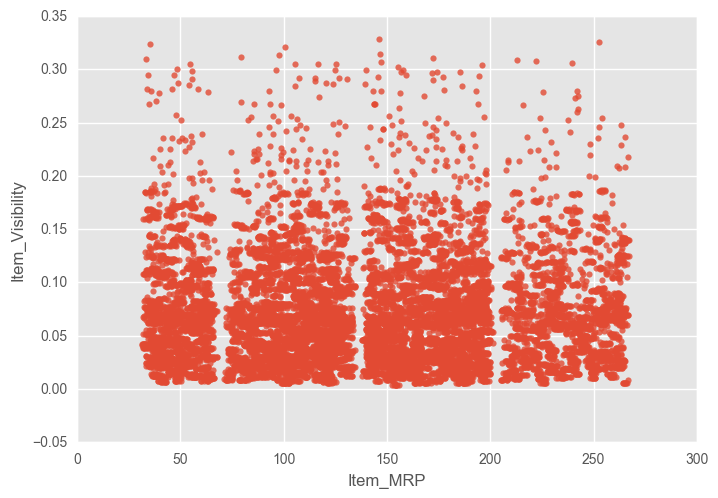

In [180]:
sns.regplot(x=combi.Item_MRP, y=combi.Item_Visibility, fit_reg=False)

C:\Users\Himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


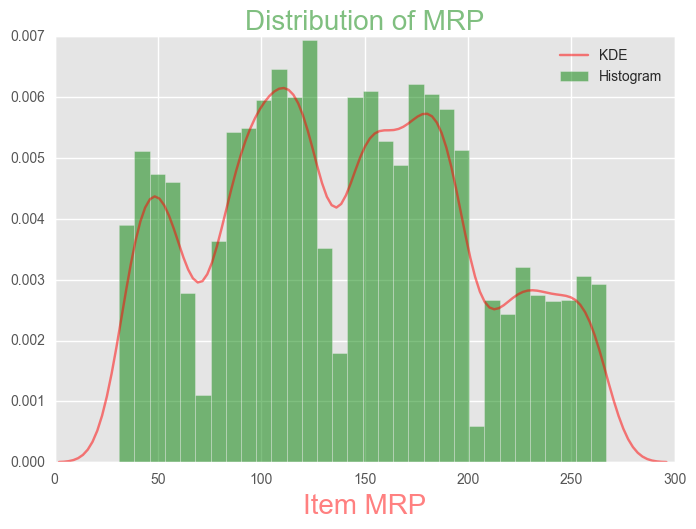

In [181]:
# There seems to be clear distinction in the MRP
# can be binned into 4 bins
ax = sns.distplot(a=combi.Item_MRP, 
             hist_kws={'color':'green', 'alpha':0.5, 'label':'Histogram'}, 
             kde_kws={'color':'red', 'alpha':0.5, 'label':'KDE'})
ax.set_title('Distribution of MRP', alpha=0.5, size=20, color='green')
ax.set_xlabel('Item MRP', alpha=0.5, size=20, color='red')


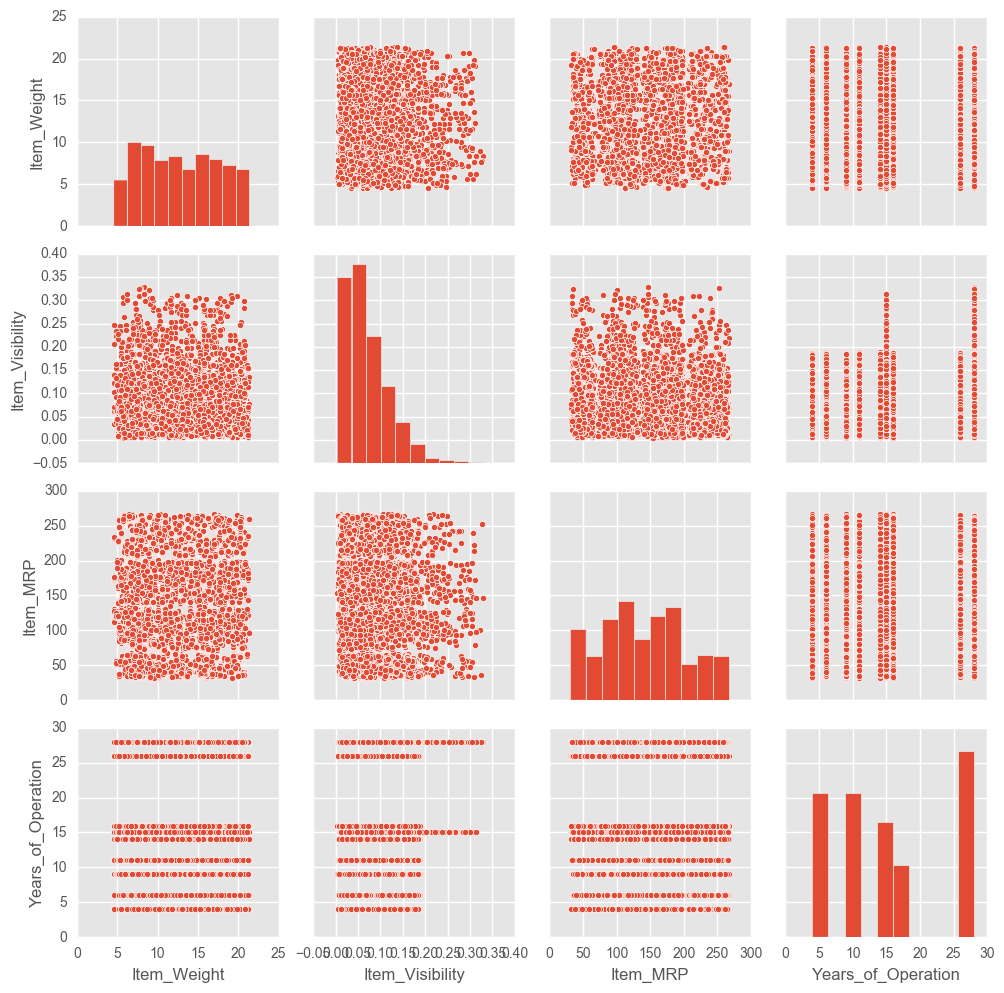

In [182]:
sns.pairplot(combi[['Item_Weight','Item_Visibility','Item_MRP','Years_of_Operation']])

In [183]:
Item_Identifier_value_count = combi.Item_Identifier.value_counts()
combi['Item_Identifier_count'] = combi.Item_Identifier.apply(lambda x : Item_Identifier_value_count[x])

In [184]:
Outlet_Identifier_value_count = combi.Outlet_Identifier.value_counts()
combi['Outlet_Identifier_count'] = combi.Outlet_Identifier.apply(lambda x : Outlet_Identifier_value_count[x])

In [185]:
#combi_hotencoded = pd.get_dummies(combi, columns=['Item_Identifier_Type','Item_Fat_Content','Item_Type','Outlet_Identifier',
#                               'Outlet_Establishment_Year','Outlet_Size','Outlet_Location_Type','Outlet_Type'])

combi_hotencoded = pd.get_dummies(combi, columns=['Item_Identifier_Type','Item_Fat_Content','Item_Type','Outlet_Identifier',
                               'Outlet_Size','Outlet_Location_Type','Outlet_Type'])

In [186]:
combi_hotencoded.columns

Index(['Item_Identifier', 'Item_Identifier_Name', 'Item_Weight',
       'Item_Visibility', 'Item_MRP', 'Years_of_Operation',
       'Item_Outlet_Sales', 'Item_Identifier_count', 'Outlet_Identifier_count',
       'Item_Identifier_Type_DR', 'Item_Identifier_Type_FD',
       'Item_Identifier_Type_NC', 'Item_Fat_Content_LOW FAT',
       'Item_Fat_Content_OTHERS', 'Item_Fat_Content_REGULAR',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT

In [187]:
combi_hotencoded = combi_hotencoded[['Item_Identifier', 'Item_Identifier_Name', 'Item_Weight',
       'Item_Visibility', 'Item_MRP','Years_of_Operation', 'Item_Identifier_count', 'Outlet_Identifier_count',
       'Item_Identifier_Type_DR', 'Item_Identifier_Type_FD',
       'Item_Identifier_Type_NC', 'Item_Fat_Content_LOW FAT',
       'Item_Fat_Content_OTHERS', 'Item_Fat_Content_REGULAR',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3','Item_Outlet_Sales']]

In [188]:
combi_hotencoded

,Item_Identifier,Item_Identifier_Name,Item_Weight,Item_Visibility,Item_MRP,Years_of_Operation,Item_Identifier_count,Outlet_Identifier_count,Item_Identifier_Type_DR,Item_Identifier_Type_FD,Item_Identifier_Type_NC,Item_Fat_Content_LOW FAT,Item_Fat_Content_OTHERS,Item_Fat_Content_REGULAR,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,A15,9.300,0.016047,249.8092,14,9,1550,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,3735.1380
1,DRC01,C01,5.920,0.019278,48.2692,4,9,1546,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,443.4228
2,FDN15,N15,17.500,0.016760,141.6180,14,10,1550,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,2097.2700
3,FDX07,X07,19.200,0.107671,182.0950,15,9,925,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,732.3800
4,NCD19,D19,8.930,0.065764,53.8614,26,9,1553,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,994.7052
5,FDP36,P36,10.395,0.070646,51.4008,4,8,1546,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,556.6088
6,FDO10,O10,13.650,0.012741,57.6588,26,10,1553,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,343.5528
7,FDP10,P10,19.000,0.127470,107.7622,28,10,1559,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,4022.7636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14196,FDF46,F46,7.070,0.094053,116.0834,4,9,1546,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,NaN


In [189]:
train_processed = combi_hotencoded.loc[:len(train)-1, :]
test_processed = combi_hotencoded.loc[len(train):, :]
train_processed = train_processed.reset_index(drop=True)
test_processed = test_processed.reset_index(drop=True)
test_processed = test_processed.drop('Item_Outlet_Sales', axis='columns')
print(train_processed.shape)
print(test_processed.shape)

(8523, 51)
(5681, 50)


In [190]:
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

# scaling didn't help
Xscaled = scale(train_processed[['Item_Weight','Item_Visibility','Item_MRP','Years_of_Operation',
                                 'Item_Identifier_count','Outlet_Identifier_count']])
train_processed.loc[:,'Item_Weight'] = Xscaled[:,0]
train_processed.loc[:,'Item_Visibility'] = Xscaled[:,1]
train_processed.loc[:,'Item_MRP'] = Xscaled[:,2]
train_processed.loc[:,'Years_of_Operation'] = Xscaled[:,3]
train_processed.loc[:,'Item_Identifier_count'] = Xscaled[:,4]
train_processed.loc[:,'Outlet_Identifier_count'] = Xscaled[:,5]

In [36]:
def do_regression_gridcv(estimator, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=-1, n_folds=5):
    if parameters:
        gs = GridSearchCV(estimator=estimator, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
        gs.fit(Xtrain, ytrain)
        estimator = gs.best_estimator_
        print('###########################################')
        print('Best parameter: ', gs.best_params_, '\nBest score: ', gs.best_score_, '\nGrid Score: ', gs.grid_scores_)
    else:
        estimator.fit(Xtrain, ytrain)
    
    training_mse = mean_squared_error(ytrain, estimator.predict(Xtrain))
    test_mse = mean_squared_error(ytest, estimator.predict(Xtest))
    print('###############################################')
    print('Training RMSE : ', np.sqrt(training_mse))
    print('Test RMSE : ', np.sqrt(test_mse))
    print('###############################################')
    return estimator

def plot_feature_importance(estimator, predictors, plot_graph=True):
    feature_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    if plot_graph:
        plt.subplots(figsize=(10,15))
        sns.barplot(x=feature_imp, y=feature_imp.index, palette='cubehelix')
    return feature_imp

In [37]:
features = ['Item_Weight',
       'Item_Visibility', 'Item_MRP','Years_of_Operation', 'Item_Identifier_count', 'Outlet_Identifier_count',
       'Item_Identifier_Type_DR', 'Item_Identifier_Type_FD',
       'Item_Identifier_Type_NC', 'Item_Fat_Content_LOW FAT',
       'Item_Fat_Content_OTHERS', 'Item_Fat_Content_REGULAR',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3']

label = 'Item_Outlet_Sales'

In [150]:
Xtrain, Xtest, ytrain, ytest = train_test_split(train_processed[features], 
                                                train_processed[label], train_size=0.7, random_state=30)

# RandomForest Regressor

In [191]:
%%time
rfReg = RandomForestRegressor(oob_score=True, random_state=20)
parameters = {'n_estimators':[500,1000,1200], 'max_features':['sqrt','log2',0.5,0.2], 'min_samples_leaf':[5,10,20,50,80]}
rfReg = do_regression_gridcv(rfReg, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=-1, n_folds=5)

###########################################
Best parameter:  {'n_estimators': 500, 'min_samples_leaf': 50, 'max_features': 0.5} 
Best score:  0.5994141066415317 
Grid Score:  [mean: 0.55673, std: 0.00799, params: {'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 'sqrt'}, mean: 0.55871, std: 0.00714, params: {'n_estimators': 1000, 'min_samples_leaf': 5, 'max_features': 'sqrt'}, mean: 0.55915, std: 0.00718, params: {'n_estimators': 1200, 'min_samples_leaf': 5, 'max_features': 'sqrt'}, mean: 0.54086, std: 0.00892, params: {'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 'sqrt'}, mean: 0.54403, std: 0.00872, params: {'n_estimators': 1000, 'min_samples_leaf': 10, 'max_features': 'sqrt'}, mean: 0.54459, std: 0.00884, params: {'n_estimators': 1200, 'min_samples_leaf': 10, 'max_features': 'sqrt'}, mean: 0.52200, std: 0.00838, params: {'n_estimators': 500, 'min_samples_leaf': 20, 'max_features': 'sqrt'}, mean: 0.52543, std: 0.00863, params: {'n_estimators': 1000, 'min_sa

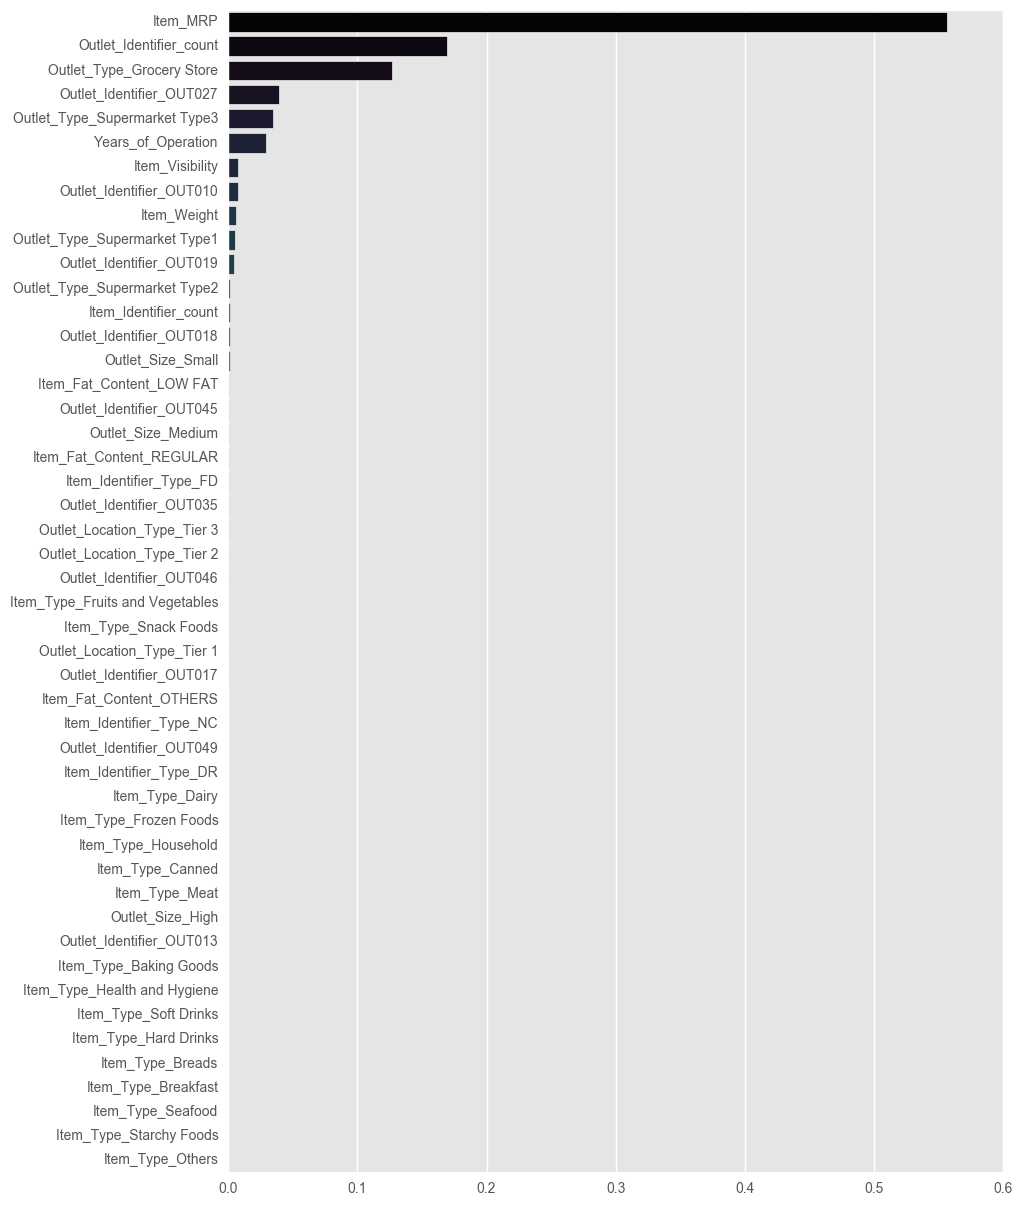

In [192]:
rf_feature_imp = plot_feature_importance(rfReg, Xtrain.columns)

In [199]:
%%time
# These parameter gave best results so far with 10 best features. 
# LB rank changed to 93 from 215 just by random forest parameter tuning
# LB Score 1150.749873

rfReg = RandomForestRegressor(oob_score=True, random_state=20, max_features=0.5, n_estimators=500,min_samples_leaf=50)
rfReg.fit(train_processed[rf_feature_imp.index[:10]], train_processed[label])

Wall time: 4.45 s


In [200]:
test_pred = rfReg.predict(test_processed[rf_feature_imp.index[:10]])
subrf = pd.read_csv('SampleSubmission.csv')
subrf.Item_Outlet_Sales = test_pred
subrf.to_csv('subrf_py.csv', index=False)

# GBM Regression

In [109]:
%%time
gbmReg = GradientBoostingRegressor(random_state=10)
parameters = {'n_estimators':[50,70,100,120,150], 'max_depth':[1,2,3,5], 
              'learning_rate':[0.01,0.05,0.1,0.5], 'max_features':['auto',0.5,1]}
gbmReg = do_regression_gridcv(gbmReg, parameters, Xtrain, ytrain, Xtest, ytest, n_jobs=-1)

###########################################
Best parameter:  {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'max_features': 'auto'} 
Best score:  0.3008126028223418 
Grid Score:  [mean: 0.10935, std: 0.00316, params: {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 'auto'}, mean: 0.13514, std: 0.00245, params: {'n_estimators': 70, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 'auto'}, mean: 0.16430, std: 0.00197, params: {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 'auto'}, mean: 0.17888, std: 0.00217, params: {'n_estimators': 120, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 'auto'}, mean: 0.19536, std: 0.00297, params: {'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 'auto'}, mean: 0.10784, std: 0.00284, params: {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.01, 'max_features': 0.5}, mean: 0.13374, std: 0.00252, params: {'n_estimators': 70, 'max_depth': 1, '

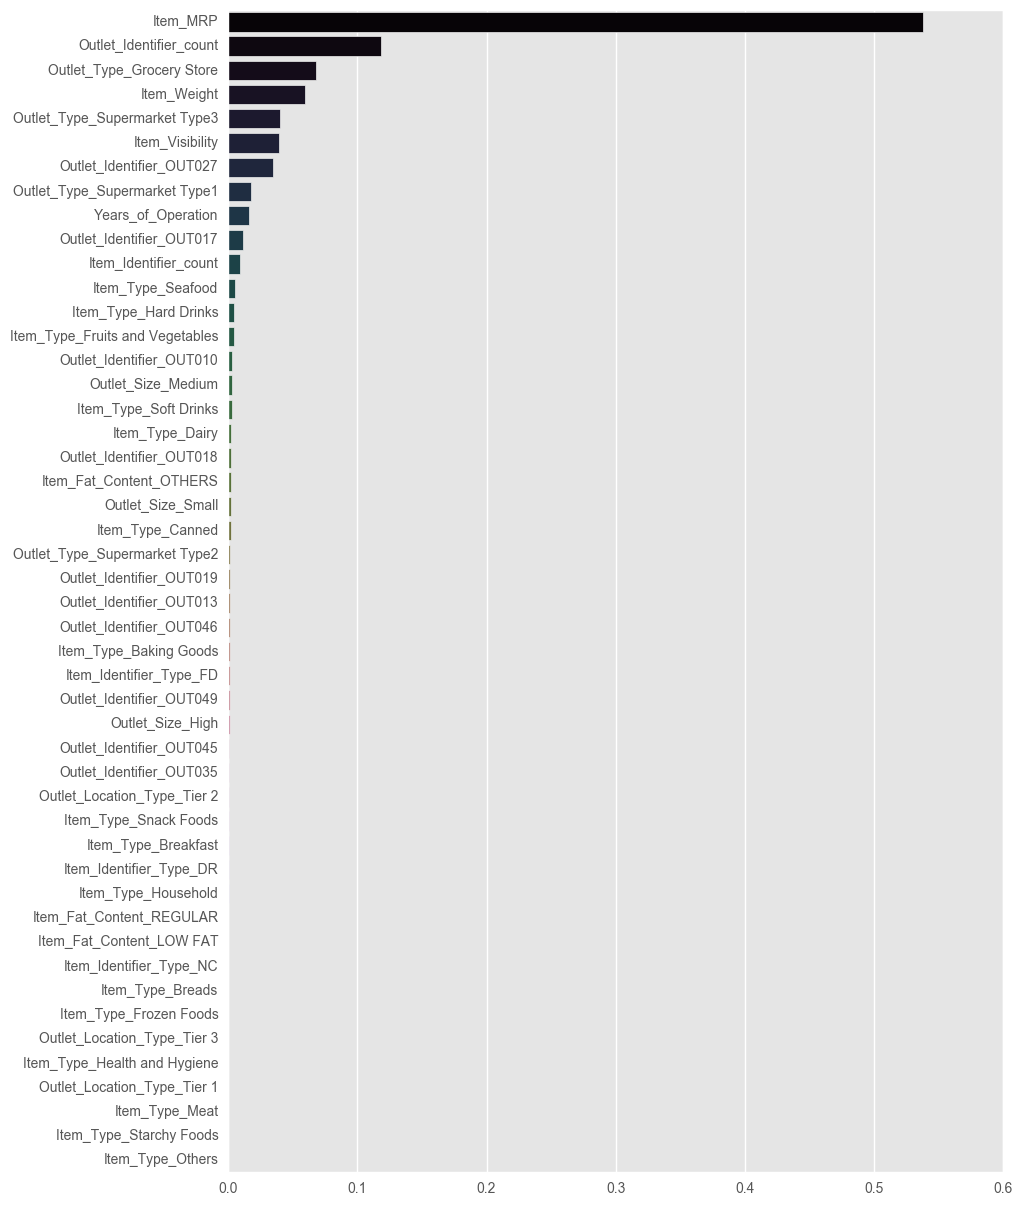

In [60]:
feature_imp = plot_feature_importance(gbmReg, Xtrain.columns)

In [70]:
gbmReg = GradientBoostingRegressor(random_state=20, n_estimators=100, max_depth=3, learning_rate=0.05, max_features=0.5)
gbmReg.fit(train_processed[feature_imp.index[:10]], train_processed[label])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=0.5,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=20, subsample=1.0, verbose=0,
             warm_start=False)

In [71]:
test_pred_gbm = gbmReg.predict(test_processed[feature_imp.index[:10]])
sub_gbm = pd.read_csv('SampleSubmission.csv')
sub_gbm.Item_Outlet_Sales = test_pred
sub_gbm.to_csv('sub1_gbm_py.csv', index=False)